# GENERATOR
We need to compute:
1. Sample a N(100) vector
2. run forward pass
3. calculate loss
4. update weights

# Discriminator
1. Sample 16 MNIST data
2. Sample 16 generator images
3. Label and shuffle
4. Forward
5. Loss
6. Update

In [1]:
from model import Generator, GeneratorMLP, Discriminator
import matplotlib.pyplot as plt
import torch

Sampled z: torch.Size([16, 100])
Generated images: torch.Size([16, 1, 28, 28])


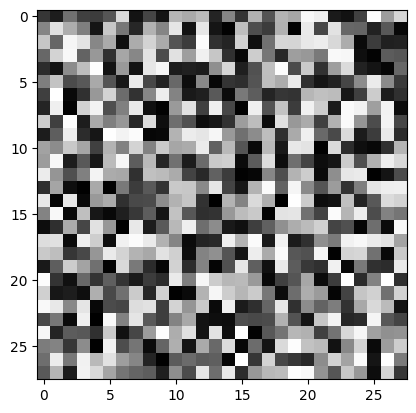

In [2]:
torch.manual_seed(42)

SAMPLE_Z_SIZE: int = 100
BATCH_SIZE: int = 16
sampled_z: torch.Tensor = torch.normal(mean=0, std=1, size=(BATCH_SIZE, SAMPLE_Z_SIZE))
print(f"Sampled z: {sampled_z.shape}")

# Forward pass
generator = GeneratorMLP()
generated_images = generator(sampled_z)

print(f"Generated images: {generated_images.shape}")
plt.imshow(generated_images[0].detach().numpy().reshape(28, 28), cmap="gray")


In [3]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

def wasserstein_loss(y_true, y_pred):
    return torch.mean(y_true) * torch.mean(y_pred)


def generator_loss(y_pred):
    return -torch.mean(y_pred)

discriminator = Discriminator().to(device)
generator = GeneratorMLP().to(device)

discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)

Using device: mps


In [4]:
def train_step(generator, discriminator, real_images, sampled_z, discriminator_optimizer, generator_optimizer, train_generator=False, device=device,):
    discriminator_optimizer.zero_grad()
    # 1. Move data to device
    real_images = real_images.to(device) # [16, 1, 28, 28]

    fake_images = generator(sampled_z) # [16, 1, 28, 28]

    # 2. Forward pass
    real_preds = discriminator(real_images) # [16, 1, 1, 1]
    fake_preds = discriminator(fake_images) # [16, 1, 1, 1]

    # 3. Calculate loss
    real_loss = wasserstein_loss(real_preds, torch.ones_like(real_preds))
    fake_loss = wasserstein_loss(fake_preds, -torch.ones_like(fake_preds))
    total_loss = real_loss + fake_loss

    # 4. Backward pass
    total_loss.backward()
    discriminator_optimizer.step()

    if train_generator:
        generator.zero_grad()
        sampled_z = sampled_z.to(device) # [16, 100]
        fake_images = generator(sampled_z) # [16, 1, 28, 28]
        fake_preds = discriminator(fake_images) # [16, 1, 1, 1]
        fake_loss = generator_loss(fake_preds)
        fake_loss.backward()
        generator_optimizer.step()

    return real_loss.item()

In [5]:
from data_setup import create_dataloaders
from utils import save_10_images
from tqdm import tqdm

train_dataloader = create_dataloaders(data_dir="data", batch_size=16, num_workers=1)

for i, (real_images, _) in enumerate(train_dataloader):
    print(real_images.shape)
    break

/Users/rmartin0/Developer/Study/DeepL/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([16, 1, 28, 28])


In [ ]:
testing_sample_z_size = torch.normal(mean=0, std=1, size=(BATCH_SIZE, SAMPLE_Z_SIZE))

def train(generator, discriminator, dataset, discriminator_optimizer, generator_optimizer, epochs=100, device=device,):
    for epoch in range(epochs):
        for i, (real_images, _) in tqdm(enumerate(dataset)):
            sampled_z = torch.normal(mean=0, std=1, size=(SAMPLE_Z_SIZE, SAMPLE_Z_SIZE)).to(device)
            if i % 5 == 0:
                train_generator = True
            else:
                train_generator = False
            train_step(generator, discriminator, real_images, sampled_z, discriminator_optimizer, generator_optimizer, train_generator, device)
            if i % 100 == 0:
                save_10_images(generator(sampled_z), (epoch+1)*i)
                # Print images
                plt.imshow(real_images[0].squeeze(), cmap="gray")
                print(f"Epoch {epoch} completed")




In [ ]:
train(generator, discriminator, train_dataloader, discriminator_optimizer, generator_optimizer, epochs=100, device=device)

KeyboardInterrupt: 

: 

In [ ]:

save_10_images(generator(torch.randn(16, 100)), 0)

RuntimeError: Tensor for argument input is on cpu but expected on mps